Spatial Temporal Prediction Model for Soil Moisture
---------------------------------------------------

This notebook generates soil moisture prediction maps and their uncertainty for multiple time intervals
model training data is based on daily and weekly averaged data from soil moisture probes and multiple
spatial-temporal dependent covariates. 

The prediction model that is selected here is based on Gaussian Process regression with Random Forest Regression as base function.

The Gaussian Process models the spatial land temporal correlations between data and prediction locations. 
Here we use a squared exponential kernel with two joint length-scales, one for spatial and one for temporal distance (see optimized hyperparameters of the GP below).

User settings, such as input/output paths and all other options, are set in the settings file, e.g.:

`settings_soilmod_moisture_predict_2020.yaml`

This package is part of the machine learning project developed for the Agricultural Research Federation (AgReFed).



## Library imports

In [1]:
# Import libraries
import os 
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Import model 
sys.path.append('../python_scripts')
import soilmod_predict_st as soilmod


 ## Settings file

 All settings are specified in the .yaml file to make analysis repeatable.

In [2]:
# Define name of settings file to save configuration
fname_settings = 'settings_soilmod_moisture_predict_2020.yaml'
path_settings = 'settings'

### Reading and process settings

In [3]:
settings = soilmod.preprocess_settings(os.path.join(path_settings,fname_settings))
print("Main Settings:")
print("----------------")
for key in settings.__dict__:
    if key != "name_features":
        print(f"settings.{key} : {settings.__dict__[key]}")

Main Settings:
----------------
settings.inpath : ../../../data/Llara/bars/rescaled_csv/
settings.outpath : ../../../results/Llara_pointpredict_rf-gp_moisture_2020/
settings.infname : Soilmoisture_all_covariates_weekly_2020.csv
settings.gridname : grid_covariates_spatial_temporal_weekly_2020.csv
settings.project_crs : EPSG:28355
settings.name_target : D1
settings.model_function : rf-gp
settings.xyvoxsize : 20
settings.zvoxsize : 1
settings.colname_xcoord : EASTING
settings.colname_ycoord : NORTHING
settings.tmin : 0
settings.tmax : 54
settings.list_t_pred : [14, 27, 40]
settings.colname_tcoord : week
settings.integrate_block : False
settings.xyblocksize : 20
settings.tblocksize : 1
settings.integrate_polygon : False
settings.polyname : testpolytri.gpkg
settings.name_features_grid : ['AVERAGE-Soil-Temp-10cm', 's2_barest_earth_channel1_mean', 'Landscape_Topographic_wetness_index', 'TOTAL-Rain-Gauge', 'Landscape_Slope_median_300m', 'Landscape_MrVBF', 'DEM']
settings.colname_zcoord : week


In [4]:
# Print features selected
print("Features Selected:")
print("----------------")
for key in settings.__dict__:
    if key == "name_features":
        print(f"settings.{key}:")
        for feature in settings.name_features:
            print(f"   '{feature}'")

Features Selected:
----------------
settings.name_features:
   'AVERAGE-Soil-Temp-10cm'
   's2_barest_earth_channel1_mean'
   'Landscape_Topographic_wetness_index'
   'TOTAL-Rain-Gauge'
   'Landscape_Slope_median_300m'
   'Landscape_MrVBF'
   'DEM'


### Train model and generate prediction

In [5]:
if settings.integrate_block:
    # Only if block integration is set
    print('Generating Block Model and predictions for temporal slices...')
    mu_3d, std_3d = soilmod.model_blocks(settings)
else:
    # default model for point predictions
    print('Generating Point Model and predictions for temporal slices...')
    mu_3d, std_3d = soilmod.model_points(settings)

print("Prediction Mean, Median, Std, 25Perc, 75Perc:", np.round([np.nanmean(mu_3d), np.median(mu_3d[~np.isnan(mu_3d)]), 
    np.nanstd(mu_3d), np.percentile(mu_3d[~np.isnan(mu_3d)],25), np.percentile(mu_3d[~np.isnan(mu_3d)],75)] 
    ,3))
print("Uncertainty Mean, Median, Std, 25Perc, 75Perc:", np.round([np.nanmean(std_3d), np.median(std_3d[~np.isnan(std_3d)]),
    np.nanstd(std_3d), np.percentile(std_3d[~np.isnan(std_3d)],25), np.percentile(std_3d[~np.isnan(std_3d)],75)],3))
print('')
print('Predictions finished')
print(f'All results are saved in output directory {settings.outpath}')

Generating Point Model and predictions for temporal slices...
--- Parameter Settings ---
Model Function: rf-gp
Target Name: D1
Prediction geometry: Point
x,y,z voxsize: (20, 20, 1)
--------------------------
Reading in data...
Optimizing GP hyperparameters...
Mean Input Noise:  1.5173970467413807
Optimized Hyperparameters (amplitude, y_noise_fac, lengthscale_z, lengths_xy): [2.85755769e-02 1.66100351e-04 7.43124883e+00 2.00000000e+04]
Marginal Log Likelihood:  -2235.7063787189472
Computing slices at time: 14
Number of mini-batches per slice:  23


  4%|▍         | 1/23 [00:00<00:14,  1.55it/s]

Logl:  -2235.7063787189472


100%|██████████| 23/23 [00:05<00:00,  4.05it/s]


saving data and generating plots...
Creating plots...
Saving results as geo tif...
Computing slices at time: 27
Number of mini-batches per slice:  23


100%|██████████| 23/23 [00:05<00:00,  4.24it/s]


saving data and generating plots...
Creating plots...
Saving results as geo tif...
Computing slices at time: 40
Number of mini-batches per slice:  23


100%|██████████| 23/23 [00:05<00:00,  4.22it/s]


saving data and generating plots...
Creating plots...
Saving results as geo tif...
Prediction Mean, Median, Std, 25Perc, 75Perc: [0.197 0.201 0.016 0.184 0.209]
Uncertainty Mean, Median, Std, 25Perc, 75Perc: [0.016 0.016 0.005 0.013 0.018]

Predictions finished
All results are saved in output directory ../../../results/Llara_pointpredict_rf-gp_moisture_2020/


## Show Results

Here we show some of the prediction results.

Note that the optimized GP amplitude is very small: 0.0286 (first term of the hyperparameter printout above). This means that the model for the training data is primarily dominated by the Random Forest base function and the GP regression adds only a marginal improvement. This indicates that no significant spatial correlation can be found after taking account the mean trends given by the Random Forest.

### List of output files

This includes images as png as well as geo-referenced `.tif` images that can be used for further processing or GIS analysis

In [6]:
imgpath = os.path.join(settings.outpath, 'Predictions')
files = os.listdir(imgpath)
#allfiles = [name for name in files if name.endswith('.png')]
print('Image files generated: ', files)

Image files generated:  ['Std_D1_t040.tif', 'Pred_D1_t014.tif', 'Pred_D1_t014.png', 'Std_D1_t027.tif', 'Pred_D1_mean.png', 'Std_D1_t014.tif', 'Pred_D1_t027.png', 'Pred_D1_t040.tif', 'Pred_D1_t027.tif', 'Pred_D1_mean2.png', 'Pred_D1_t040.png']


### Prediction for Top Soil Moisture ('D1') in 2020

Predictions are made for the 1st week of April, July, and October 2020.

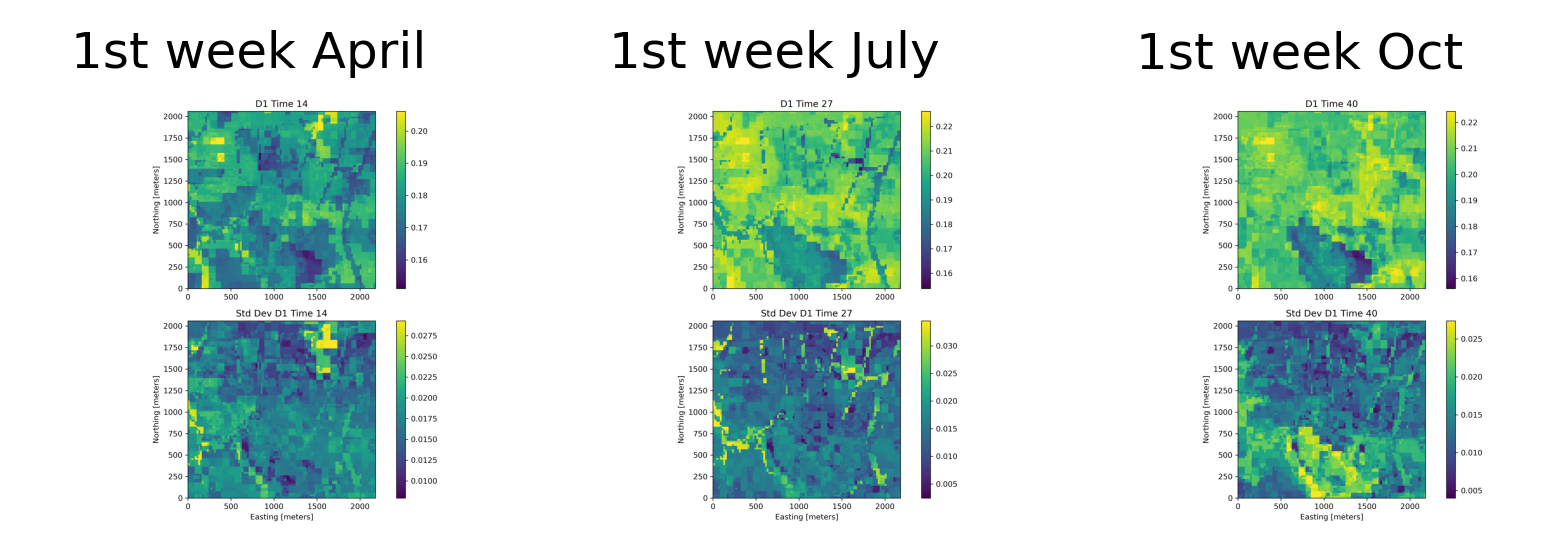

In [7]:
    fig, ax = plt.subplots(1,3, dpi =300)
    img = imread(f"{imgpath}/Pred_D1_t014.png", format='PNG')
    ax[0].set_axis_off()
    ax[0].imshow(img)
    ax[0].set_title('1st week April')
    img2 = imread(f"{imgpath}/Pred_D1_t027.png", format='PNG')
    ax[1].set_axis_off()
    ax[1].imshow(img2)
    ax[1].set_title('1st week July')
    img3 = imread(f"{imgpath}/Pred_D1_t040.png", format='PNG')
    ax[2].set_axis_off()
    ax[2].imshow(img3)
    ax[2].set_title('1st week Oct')
    fig.show()

### Averaged Top Soil Moisture Prediction in 2020

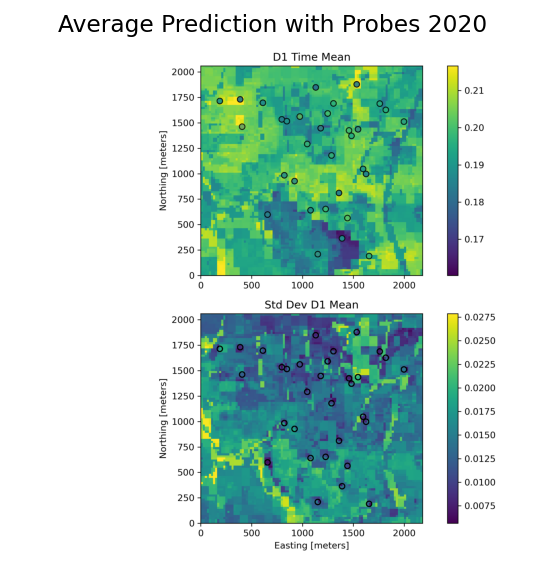

In [8]:
    fig, ax = plt.subplots(1, dpi =140)
    img = imread(f"{imgpath}/Pred_D1_mean2.png", format='PNG')
    ax.set_axis_off()
    ax.imshow(img)
    ax.set_title('Average Prediction with Probes 2020')
    plt.show()

## Analysis for 2021

Same analysis as above but for 2021

In [9]:
# Read settings file
fname_settings = 'settings_soilmod_moisture_predict_2021.yaml'
settings = soilmod.preprocess_settings(os.path.join(path_settings,fname_settings))

# Run Model
if settings.integrate_block:
    # Only if block integration is set
    print('Generating Block Model and predictions for temporal slices...')
    mu_3d, std_3d = soilmod.model_blocks(settings)
else:
    # default model for point predictions
    print('Generating Point Model and predictions for temporal slices...')
    mu_3d, std_3d = soilmod.model_points(settings)

print("Prediction Mean, Median, Std, 25Perc, 75Perc:", np.round([np.nanmean(mu_3d), np.median(mu_3d[~np.isnan(mu_3d)]), 
    np.nanstd(mu_3d), np.percentile(mu_3d[~np.isnan(mu_3d)],25), np.percentile(mu_3d[~np.isnan(mu_3d)],75)] 
    ,3))
print("Uncertainty Mean, Median, Std, 25Perc, 75Perc:", np.round([np.nanmean(std_3d), np.median(std_3d[~np.isnan(std_3d)]),
    np.nanstd(std_3d), np.percentile(std_3d[~np.isnan(std_3d)],25), np.percentile(std_3d[~np.isnan(std_3d)],75)],3))
print('')
print('Predictions finished')
print(f'All results are saved in output directory {settings.outpath}')

Generating Point Model and predictions for temporal slices...
--- Parameter Settings ---
Model Function: rf-gp
Target Name: D1
Prediction geometry: Point
x,y,z voxsize: (20, 20, 1)
--------------------------
Reading in data...
Optimizing GP hyperparameters...
Mean Input Noise:  1.469770490908055
Optimized Hyperparameters (amplitude, y_noise_fac, lengthscale_z, lengths_xy): [1.00595490e-02 1.66100351e-04 3.50410227e+02 1.99999999e+04]
Marginal Log Likelihood:  -2135.415808199591
Computing slices at time: 13
Number of mini-batches per slice:  23


  4%|▍         | 1/23 [00:00<00:14,  1.51it/s]

Logl:  -2135.415808199591


100%|██████████| 23/23 [00:06<00:00,  3.80it/s]


saving data and generating plots...
Creating plots...
Saving results as geo tif...
Computing slices at time: 26
Number of mini-batches per slice:  23


100%|██████████| 23/23 [00:05<00:00,  3.95it/s]


saving data and generating plots...
Creating plots...
Saving results as geo tif...
Computing slices at time: 39
Number of mini-batches per slice:  23


100%|██████████| 23/23 [00:05<00:00,  4.01it/s]


saving data and generating plots...
Creating plots...
Saving results as geo tif...
Prediction Mean, Median, Std, 25Perc, 75Perc: [0.21  0.212 0.012 0.202 0.219]
Uncertainty Mean, Median, Std, 25Perc, 75Perc: [0.014 0.014 0.004 0.011 0.017]

Predictions finished
All results are saved in output directory ../../../results/Llara_pointpredict_rf-gp_moisture_2021/


### Prediction for Top Soil Moisture ('D1') in 2021

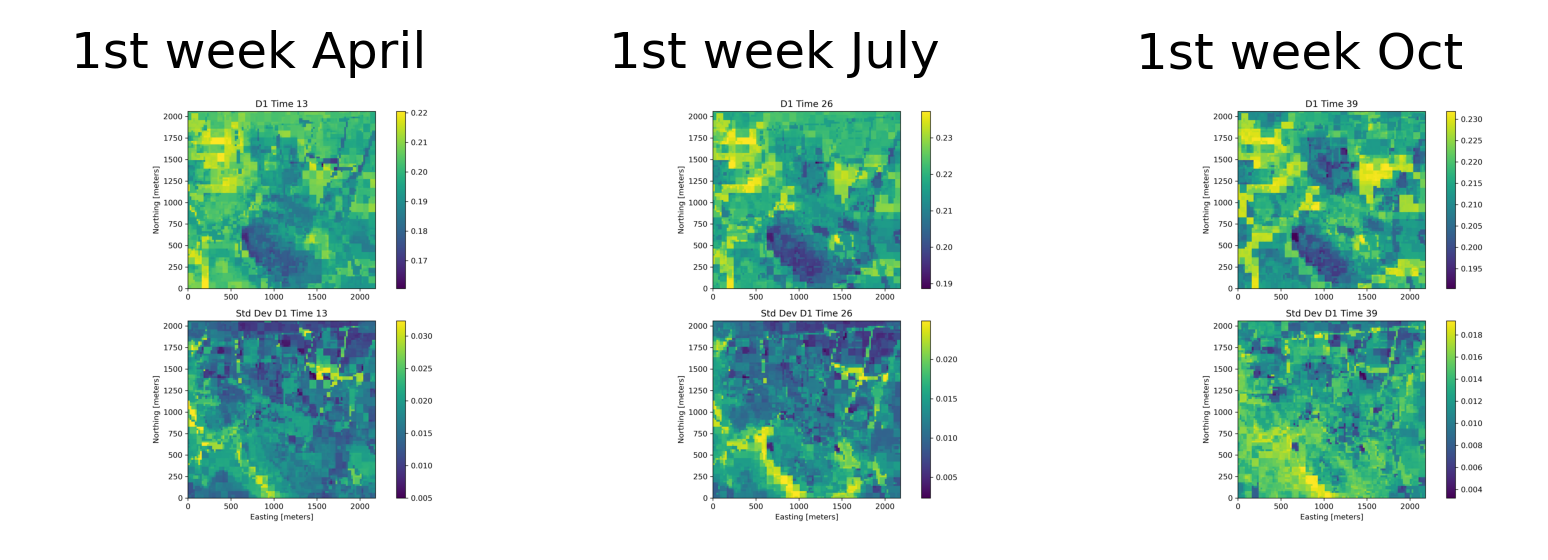

In [10]:
    imgpath = os.path.join(settings.outpath, 'Predictions')
    fig, ax = plt.subplots(1,3, dpi =300)
    img = imread(f"{imgpath}/Pred_D1_t013.png", format='PNG')
    ax[0].set_axis_off()
    ax[0].imshow(img)
    ax[0].set_title('1st week April')
    img2 = imread(f"{imgpath}/Pred_D1_t026.png", format='PNG')
    ax[1].set_axis_off()
    ax[1].imshow(img2)
    ax[1].set_title('1st week July')
    img3 = imread(f"{imgpath}/Pred_D1_t039.png", format='PNG')
    ax[2].set_axis_off()
    ax[2].imshow(img3)
    ax[2].set_title('1st week Oct')
    fig.show()

### Averaged Top Soil Moisture Prediction in 2021

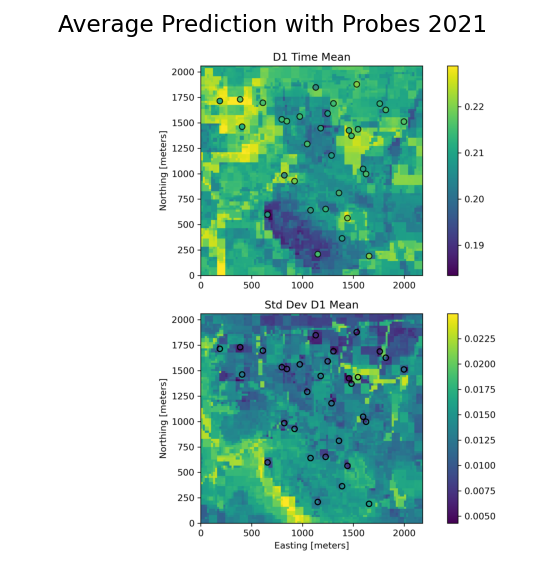

In [11]:
    fig, ax = plt.subplots(1, dpi =140)
    img = imread(f"{imgpath}/Pred_D1_mean2.png", format='PNG')
    ax.set_axis_off()
    ax.imshow(img)
    ax.set_title('Average Prediction with Probes 2021')
    plt.show()